In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import matplotlib.pyplot as plt


(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


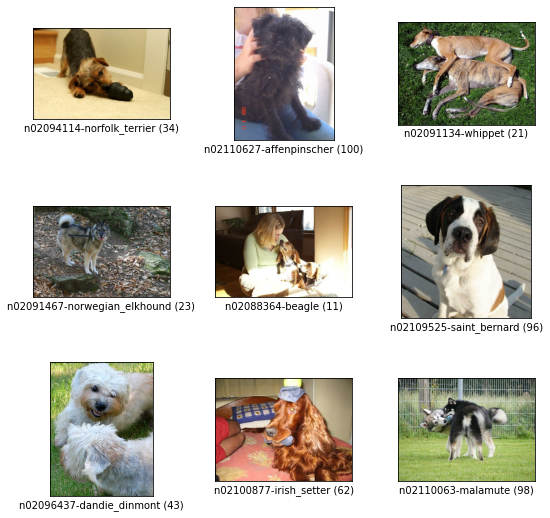

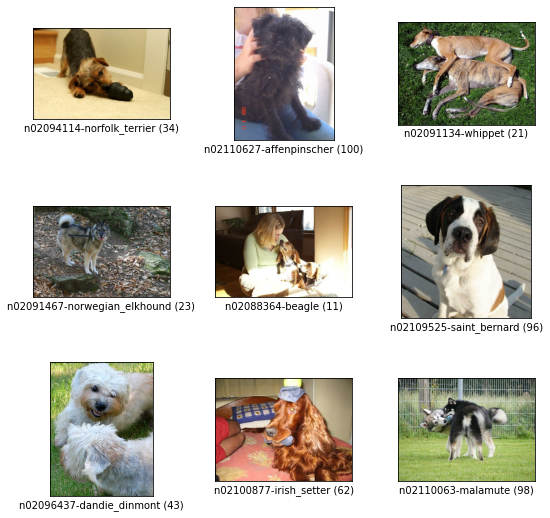

In [2]:
tfds.show_examples(ds_train, ds_info)

In [3]:
# 기본 전처리
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label


def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def augment2(image,label):
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00))
    image = tf.image.resize(image, [224, 224])
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels


def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max



In [4]:

num_classes = ds_info.features["label"].num_classes

resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

aug_cut_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
aug_mix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)


for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

ds_train_aug_cut = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_train_aug_mix = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)



94781440/94765736 [==============================] - 1s 0us/step


## 모델 훈련

In [5]:
EPOCH = 10

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/10
750/750 [==============================] - 181s 202ms/step - loss: 2.1754 - accuracy: 0.4527 - val_loss: 3.2949 - val_accuracy: 0.2182
Epoch 2/10
750/750 [==============================] - 154s 206ms/step - loss: 0.7086 - accuracy: 0.8077 - val_loss: 1.2463 - val_accuracy: 0.6410
Epoch 3/10
750/750 [==============================] - 154s 206ms/step - loss: 0.2219 - accuracy: 0.9542 - val_loss: 0.9675 - val_accuracy: 0.7118
Epoch 4/10
750/750 [==============================] - 155s 207ms/step - loss: 0.0651 - accuracy: 0.9937 - val_loss: 0.9221 - val_accuracy: 0.7338
Epoch 5/10
750/750 [==============================] - 154s 206ms/step - loss: 0.0290 - accuracy: 0.9988 - val_loss: 0.9117 - val_accuracy: 0.7421
Epoch 6/10
750/750 [==============================] - 154s 206ms/step - loss: 0.0172 - accuracy: 0.9996 - val_loss: 0.9190 - val_accuracy: 0.7408
Epoch 7/10
750/750 [==============================] - 154s 205ms/step - loss: 0.0128 - accuracy: 0.9998 - val_loss: 0.9373 -

In [6]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 162s 207ms/step - loss: 2.2660 - accuracy: 0.4348 - val_loss: 3.0009 - val_accuracy: 0.2612
Epoch 2/10
750/750 [==============================] - 154s 206ms/step - loss: 0.9448 - accuracy: 0.7262 - val_loss: 1.2858 - val_accuracy: 0.6336
Epoch 3/10
750/750 [==============================] - 154s 206ms/step - loss: 0.4983 - accuracy: 0.8624 - val_loss: 1.1384 - val_accuracy: 0.6726
Epoch 4/10
750/750 [==============================] - 154s 206ms/step - loss: 0.2658 - accuracy: 0.9377 - val_loss: 1.0602 - val_accuracy: 0.7006
Epoch 5/10
750/750 [==============================] - 154s 206ms/step - loss: 0.1439 - accuracy: 0.9715 - val_loss: 1.0149 - val_accuracy: 0.7167
Epoch 6/10
750/750 [==============================] - 154s 206ms/step - loss: 0.0902 - accuracy: 0.9844 - val_loss: 1.0474 - val_accuracy: 0.7168
Epoch 7/10
750/750 [==============================] - 154s 205ms/step - loss: 0.0498 - accuracy: 0.9939 - val_loss: 0.9582 -

In [7]:
aug_cut_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_cut = aug_cut_resnet50.fit(
    ds_train_aug_cut, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 164s 208ms/step - loss: 3.9256 - accuracy: 0.1940 - val_loss: 3.0723 - val_accuracy: 0.2462
Epoch 2/10
750/750 [==============================] - 155s 207ms/step - loss: 3.0599 - accuracy: 0.4022 - val_loss: 1.4207 - val_accuracy: 0.6018
Epoch 3/10
750/750 [==============================] - 155s 207ms/step - loss: 2.7586 - accuracy: 0.4863 - val_loss: 1.3078 - val_accuracy: 0.6372
Epoch 4/10
750/750 [==============================] - 155s 207ms/step - loss: 2.5742 - accuracy: 0.5446 - val_loss: 1.1894 - val_accuracy: 0.6698
Epoch 5/10
750/750 [==============================] - 155s 207ms/step - loss: 2.4399 - accuracy: 0.5858 - val_loss: 1.2284 - val_accuracy: 0.6575
Epoch 6/10
750/750 [==============================] - 155s 207ms/step - loss: 2.3286 - accuracy: 0.6203 - val_loss: 1.3483 - val_accuracy: 0.6372
Epoch 7/10
750/750 [==============================] - 155s 207ms/step - loss: 2.2550 - accuracy: 0.6505 - val_loss: 1.2568 -

In [8]:
aug_mix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug_mix = aug_mix_resnet50.fit(
    ds_train_aug_mix, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 164s 208ms/step - loss: 3.7222 - accuracy: 0.2366 - val_loss: 3.8228 - val_accuracy: 0.1322
Epoch 2/10
750/750 [==============================] - 155s 207ms/step - loss: 2.9764 - accuracy: 0.4449 - val_loss: 1.6181 - val_accuracy: 0.5591
Epoch 3/10
750/750 [==============================] - 156s 207ms/step - loss: 2.6945 - accuracy: 0.5371 - val_loss: 1.3929 - val_accuracy: 0.6068
Epoch 4/10
750/750 [==============================] - 155s 207ms/step - loss: 2.5069 - accuracy: 0.6072 - val_loss: 1.3740 - val_accuracy: 0.6263
Epoch 5/10
750/750 [==============================] - 155s 207ms/step - loss: 2.3788 - accuracy: 0.6566 - val_loss: 1.3001 - val_accuracy: 0.6400
Epoch 6/10
750/750 [==============================] - 156s 207ms/step - loss: 2.3110 - accuracy: 0.6809 - val_loss: 1.3167 - val_accuracy: 0.6444
Epoch 7/10
750/750 [==============================] - 156s 208ms/step - loss: 2.2409 - accuracy: 0.7094 - val_loss: 1.2618 -

## Visualization

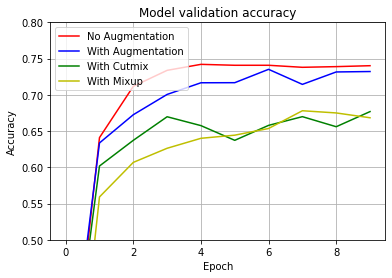

In [10]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cut.history['val_accuracy'], 'g')
plt.plot(history_resnet50_aug_mix.history['val_accuracy'], 'y')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix', 'With Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80) 
plt.show()

## 회고

10 에포크동안의 결과에 의하면, 오히려 cutmix한 결과와 mixup한 결과가 기본 augmentation한 결과와 augmentation하지 않은 결과보다 안좋은 결과를 나타냈다. 더 에포크를 늘린다면 다른 결과가 나올 수도 있지만, 한정된 시간에 한정된 컴퓨팅 자원을 이용하여, 많은 시도를 하지 못한 것이 아쉬웠다.